Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para 
filtrado espectral:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def create_gauss_filter(h, w, k_size, sigma):
    kernel_1d = cv2.getGaussianKernel(k_size, sigma)
    kernel_2d = kernel_1d @ kernel_1d.T
    
    vertical_pad = ((h - k_size) // 2, np.ceil((h - k_size) / 2).astype(int))
    horizontal_pad = ((w - k_size) // 2, np.ceil((w - k_size) / 2).astype(int))
    
    space_kernel = np.pad(kernel_2d, (vertical_pad, horizontal_pad), "constant", constant_values=0)
    
    kernel_tf = np.fft.fft2(space_kernel)
    
    return space_kernel, kernel_tf


### Parte 1:

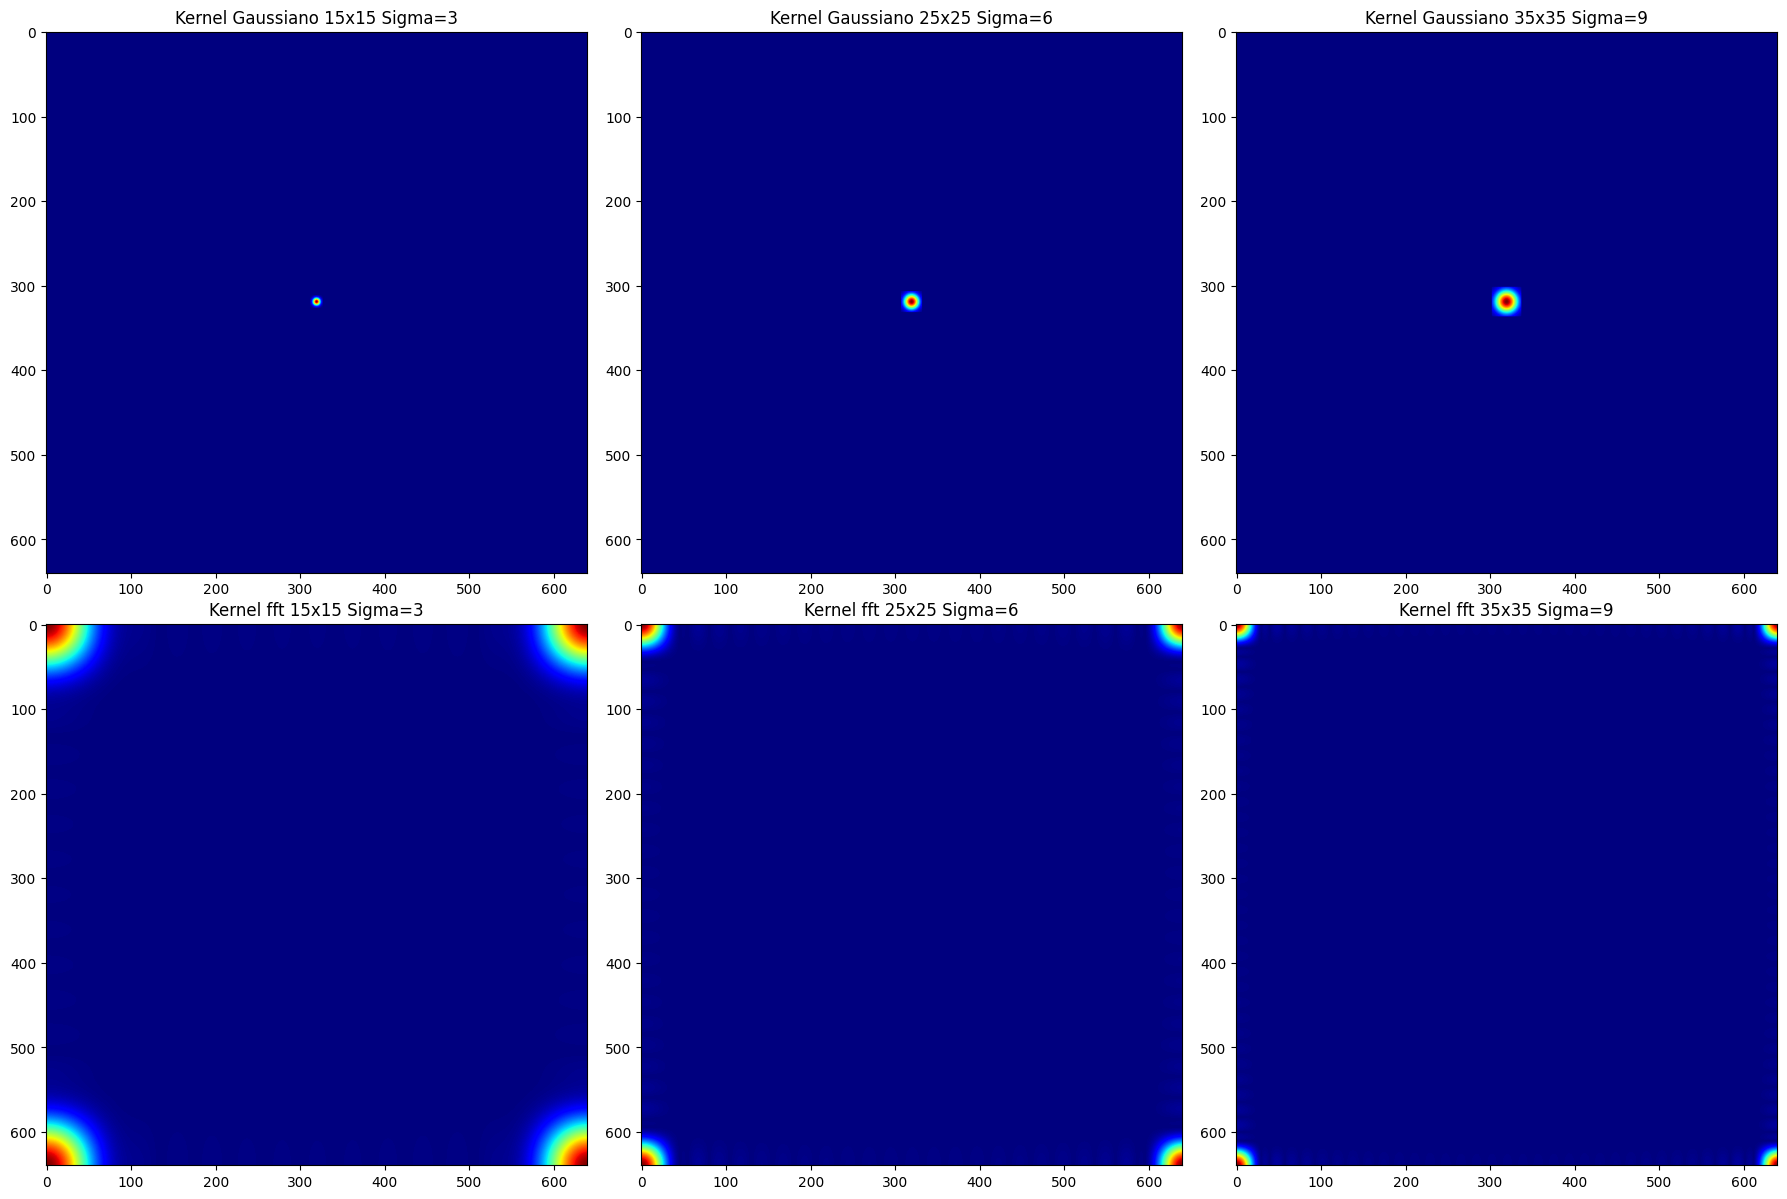

In [2]:
combinaciones = [(15, 3), (25, 6), (35, 9)]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for i, (k_size, sigma) in enumerate(combinaciones):
    kernel, kernel_tf = create_gauss_filter(640, 640, k_size, sigma)
    
    axs[0, i].imshow(kernel, cmap='jet')
    axs[0, i].set_title(f'Kernel Gaussiano {k_size}x{k_size} Sigma={sigma}')
    
    axs[1, i].imshow(np.abs(kernel_tf), cmap='jet')
    axs[1, i].set_title(f'Kernel fft {k_size}x{k_size} Sigma={sigma}')

plt.tight_layout()
plt.show()



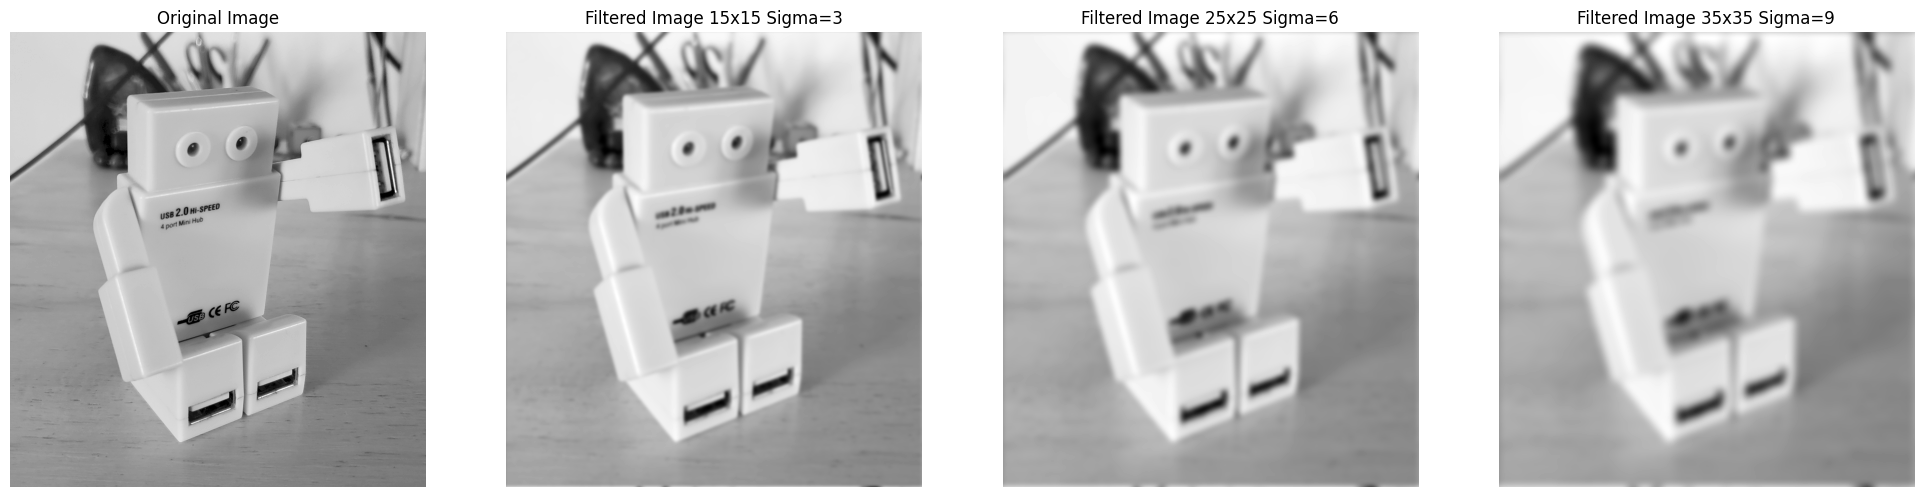

In [3]:
img = cv2.imread('CoordCrom_1.png', cv2.IMREAD_GRAYSCALE)
img_fft = np.fft.fft2(img)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

h, w = img.shape
images = [img]

for i, (k_size, sigma) in enumerate(combinaciones):
    _, kernel_tf = create_gauss_filter(h, w, k_size, sigma)
    
    filtered = img_fft * kernel_tf
    
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
    images.append(img_gauss)
    
    axs[i + 1].imshow(img_gauss, cmap='gray')
    axs[i + 1].set_title(f'Filtered Image {k_size}x{k_size} Sigma={sigma}')
    axs[i + 1].axis('off')

plt.tight_layout()
plt.show()


### Parte 2:

Image Sharpness Measure for Blurred Images in Frequency Domain:

In [4]:
def FM(input_image):
    fourier_transform = np.fft.fft2(input_image)
    centered_fourier = np.fft.fftshift(fourier_transform)
    magnitude = np.abs(centered_fourier)
    max_magnitude = np.max(magnitude)
    thresholded_count = len(fourier_transform[fourier_transform > max_magnitude/1000])
    fm_value = thresholded_count / (input_image.shape[0] * input_image.shape[1])
    return fm_value

Analysis of focus measure operators in shape-from-focus:

In [5]:
def ACM(input_image):
    input_image = np.clip(input_image, 0, 255).astype(np.uint8)
    absolute_central_moment = 0
    pixel_histogram = cv2.calcHist([input_image], [0], None, [256], [0, 256])
    mean_intensity = np.mean(input_image)
    
    for intensity_value in range(len(pixel_histogram)):
        absolute_central_moment += pixel_histogram[intensity_value] * np.abs(intensity_value - mean_intensity)
    
    normalized_acm = absolute_central_moment / (input_image.shape[0] * input_image.shape[1])
    return normalized_acm[0]

Comparativa:

In [6]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


df_metrics = pd.DataFrame(columns=['image', 'FM (Espectral)', 'ACM (Espectral)', 'FM (Espacial)', 'ACM (Espacial)'])

df_metrics = df_metrics.append({
        'image': f"Original", 
        'FM (Espectral)': FM(img), 
        'ACM (Espectral)': ACM(img), 
        'FM (Espacial)': FM(img), 
        'ACM (Espacial)': ACM(img)}, 
        ignore_index=True)

for k_size, sigma in combinaciones:
    kernel, kernel_tf = create_gauss_filter(h, w, k_size, sigma)

    img_conv = cv2.GaussianBlur(img, (k_size, k_size), sigma)

    filtered = img_fft * kernel_tf
    img_spectral = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

    df_metrics = df_metrics.append({
        'image': f"{k_size}x{k_size} Sigma={sigma}", 
        'FM (Espectral)': FM(img_spectral), 
        'ACM (Espectral)': ACM(img_spectral), 
        'FM (Espacial)': FM(img_conv), 
        'ACM (Espacial)': ACM(img_conv)}, 
        ignore_index=True)


df_metrics


,image,FM (Espectral),ACM (Espectral),FM (Espacial),ACM (Espacial)
0,Original,0.000956,32.804392,0.000956,32.804392
1,15x15 Sigma=3,0.000822,31.515472,0.000804,31.665901
2,25x25 Sigma=6,0.000598,30.154939,0.000600,30.446725
3,35x35 Sigma=9,0.000454,28.908745,0.000452,29.331637


Se observa que las métricas FM y ACM en el filtrado espacial no es muy distinta del filtrado espectral